## Libraries

In [121]:
# Instalations of additional necessary libraries
#!pip install seaborn
#!pip install yfinance
#!pip install statsmodels

In [122]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import seaborn as sns
from scipy.optimize import differential_evolution
import statsmodels.api as sm
from tabulate import tabulate
import warnings

In [123]:
# Prepare for export into PDF
warnings.filterwarnings('ignore', category=FutureWarning)

Instructions

Compute daily returns if not already done so

Perform a short exploratory analysis of your data. Discuss the expected values, covariances
and auto-covariances of your returns, How these characteristics change in time? 

## Data preprocessing

In [124]:
# Define constants
DATA_DIR = r'D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data'
RISK_FREE_FILE = r'D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\USYields2024.csv'
SP_FILE = r'D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\sp500.csv'
START_DATE = '2021-01-01'
END_DATE = '2024-10-26'
STOCK_FILES = {
    'SPLP': 'Steel Partners Holdings L.P. Stock Price History.csv',
    'TEAM': 'Atlassian Stock Price History.csv',
    'BIDU': 'Baidu Stock Price History.csv',
    'ADBE': 'Adobe Stock Price History.csv',
    'MDLZ': 'Mondelez Stock Price History.csv',
    'AMD': 'AMD Stock Price History.csv',
    'VRSN': 'Verisign Stock Price History.csv',
    'PAYX': 'Paychex Stock Price History.csv',
}

In [125]:
def load_stock_data(stock_files, start_date, end_date, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for ticker, file in stock_files.items():
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)
        df.index = df.index.date
        df.index.name = 'Date'
        output_path = os.path.join(output_dir, file)
        df.to_csv(output_path)

In [126]:
# Load Risk-Free Rate Data
def load_risk_free_rate(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    df['1 Mo'] = pd.to_numeric(df['1 Mo'], errors='coerce')
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df[['Date', '1 Mo']].dropna()
    df['Daily_Rate'] = np.log(1 + df['1 Mo'] / 100) / 252
    df.set_index('Date', inplace=True)
    return df

In [127]:
# Download
load_stock_data(STOCK_FILES, START_DATE, END_DATE, DATA_DIR)
risk_free_rate = load_risk_free_rate(RISK_FREE_FILE)
if not os.path.exists(SP_FILE):
    df = yf.download('^GSPC', start='2022-10-24', end='2024-10-25')
    df.to_csv(SP_FILE, index=False)
sp500_data = pd.read_csv(SP_FILE)

In [128]:
# Calculate Daily Returns
def calculate_daily_returns(data):
    data['Daily_Return'] = np.log(data['Close'] / data['Open'])
    return data[['Date', 'Daily_Return']]

In [129]:
# Clean Dates with Forward Fill
def clean_dates_with_ffill(stock_returns, risk_free_rate):
    risk_free_dates = pd.to_datetime(risk_free_rate.index).date
    stock_dates = stock_returns.index.tz_localize(None)
    stock_dates = pd.to_datetime(stock_dates).date
    
    missing_free = sorted(set(stock_dates) - set(risk_free_dates))
    missing_stock = sorted(set(risk_free_dates) - set(stock_dates))
    
    cleaned_stock_returns = stock_returns.copy()
    cleaned_stock_returns.index = stock_dates
    
    cleaned_risk_free_rate = risk_free_rate.copy()
    cleaned_risk_free_rate.index = risk_free_dates
    cleaned_risk_free_rate = cleaned_risk_free_rate.reindex(cleaned_stock_returns.index).ffill()
    
    return missing_free, missing_stock, cleaned_stock_returns, cleaned_risk_free_rate

Loading data into one table and filter 1 Yr risk free rate with the Date


In [130]:
# Load Stock Data and Calculate Daily Returns
daily_returns = {}
all_data = {}
for ticker, file_name in STOCK_FILES.items():
    file_path = os.path.join(DATA_DIR, file_name)
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data['Ticker'] = ticker
    daily_returns[ticker] = calculate_daily_returns(data).set_index('Date')
    all_data[ticker] = data

stock_returns = pd.concat([df['Daily_Return'].rename(ticker) for ticker, df in daily_returns.items()], axis=1)

In [131]:
# Clean the Data
filled_dates, missing_dates, clean_returns, risk_free_rate = clean_dates_with_ffill(stock_returns, risk_free_rate)

print(len(missing_dates), "days omitted for missing stock returns and", len(filled_dates), "missing risk free rates forward filled.")

missing_dates = pd.to_datetime(missing_dates)
stock_returns = stock_returns[~stock_returns.index.isin(missing_dates)]

503 days omitted for missing stock returns and 6 missing risk free rates forward filled.


In [132]:
mean_returns = stock_returns.mean()
cov_matrix = stock_returns.cov()
auto_cov = stock_returns.apply(lambda col: col.autocorr())

## Exploratory Analysis

In [133]:
# Summary of Risk-Free Rate and stock returns
print("\nDaily Returns Summary:")
print(stock_returns.describe())

print("\nRisk-Free Rate Summary:")
print(risk_free_rate.describe())


Daily Returns Summary:
             SPLP        TEAM        BIDU        ADBE        MDLZ         AMD  \
count  960.000000  960.000000  960.000000  960.000000  960.000000  960.000000   
mean     0.002203    0.000957   -0.000254   -0.000086   -0.000209   -0.000300   
std      0.020071    0.029575    0.024521    0.017442    0.010214    0.027194   
min     -0.091406   -0.106688   -0.133468   -0.076126   -0.070633   -0.108413   
25%     -0.005124   -0.015459   -0.013971   -0.009974   -0.005947   -0.015055   
50%      0.000000    0.002490   -0.000975    0.000600   -0.000132   -0.000225   
75%      0.008005    0.018334    0.011892    0.010951    0.005806    0.015178   
max      0.127833    0.109976    0.179819    0.102605    0.037771    0.109074   

             VRSN        PAYX  
count  960.000000  960.000000  
mean    -0.000052    0.000212  
std      0.012795    0.012545  
min     -0.050470   -0.062812  
25%     -0.007396   -0.007058  
50%      0.000118    0.000297  
75%      0.007493    0

In [134]:
# First 5 days
print("\n First 5 rows")
print(stock_returns.head())
print("\n Last 5 rows")
print(risk_free_rate.tail())


 First 5 rows
                SPLP      TEAM      BIDU      ADBE      MDLZ       AMD  \
Date                                                                     
2021-01-04 -0.049940 -0.012617 -0.012422 -0.030358 -0.009793  0.002061   
2021-01-05  0.005731  0.010377  0.002667 -0.000391  0.001553  0.007248   
2021-01-06  0.023289 -0.019586 -0.042286 -0.016568 -0.002072 -0.014180   
2021-01-07 -0.028560  0.023191  0.000866  0.014209  0.000693  0.041080   
2021-01-08  0.028560 -0.002206  0.056466  0.010569  0.014192 -0.014694   

                VRSN      PAYX  
Date                            
2021-01-04 -0.015517 -0.031053  
2021-01-05 -0.025389 -0.004655  
2021-01-06 -0.020735  0.012808  
2021-01-07 -0.001998  0.005917  
2021-01-08  0.007487  0.005995  

 Last 5 rows
            1 Mo  Daily_Rate
2024-10-21  4.92    0.000191
2024-10-22  4.89    0.000189
2024-10-23  4.88    0.000189
2024-10-24  4.87    0.000189
2024-10-25  4.89    0.000189


In [135]:
# Exploratory analysis


print("\nExpected Returns (Mean):")
print(mean_returns)
print("\nCovariance Matrix:")
print(cov_matrix)
print("\nAuto-covariances (Autocorrelations):")
print(auto_cov)


Expected Returns (Mean):
SPLP    0.002203
TEAM    0.000957
BIDU   -0.000254
ADBE   -0.000086
MDLZ   -0.000209
AMD    -0.000300
VRSN   -0.000052
PAYX    0.000212
dtype: float64

Covariance Matrix:
          SPLP      TEAM      BIDU      ADBE      MDLZ       AMD      VRSN  \
SPLP  0.000403  0.000049  0.000039  0.000040  0.000002  0.000060  0.000023   
TEAM  0.000049  0.000875  0.000268  0.000293  0.000033  0.000388  0.000168   
BIDU  0.000039  0.000268  0.000601  0.000152  0.000031  0.000248  0.000076   
ADBE  0.000040  0.000293  0.000152  0.000304  0.000036  0.000260  0.000123   
MDLZ  0.000002  0.000033  0.000031  0.000036  0.000104  0.000024  0.000046   
AMD   0.000060  0.000388  0.000248  0.000260  0.000024  0.000740  0.000127   
VRSN  0.000023  0.000168  0.000076  0.000123  0.000046  0.000127  0.000164   
PAYX  0.000033  0.000126  0.000073  0.000092  0.000050  0.000101  0.000081   

          PAYX  
SPLP  0.000033  
TEAM  0.000126  
BIDU  0.000073  
ADBE  0.000092  
MDLZ  0.000050 

#TBD
The expected returns show the average daily log returns for the assets. GOOGL and AVGO exhibit positive expected returns, indicating slight daily growth, while other assets, such as LULU and AMGN, have negative expected returns, suggesting slight daily losses. The covariance matrix highlights relationships in return variability between assets. For example, GOOGL and AVGO have a relatively high covariance (0.000141), suggesting they tend to move together. On the other hand, the autocovariances (or autocorrelations) suggest the persistence of daily returns over time; for instance, GOOGL and AMGN show slight positive autocorrelations, while TXN and DLTR exhibit notable negative autocorrelations.

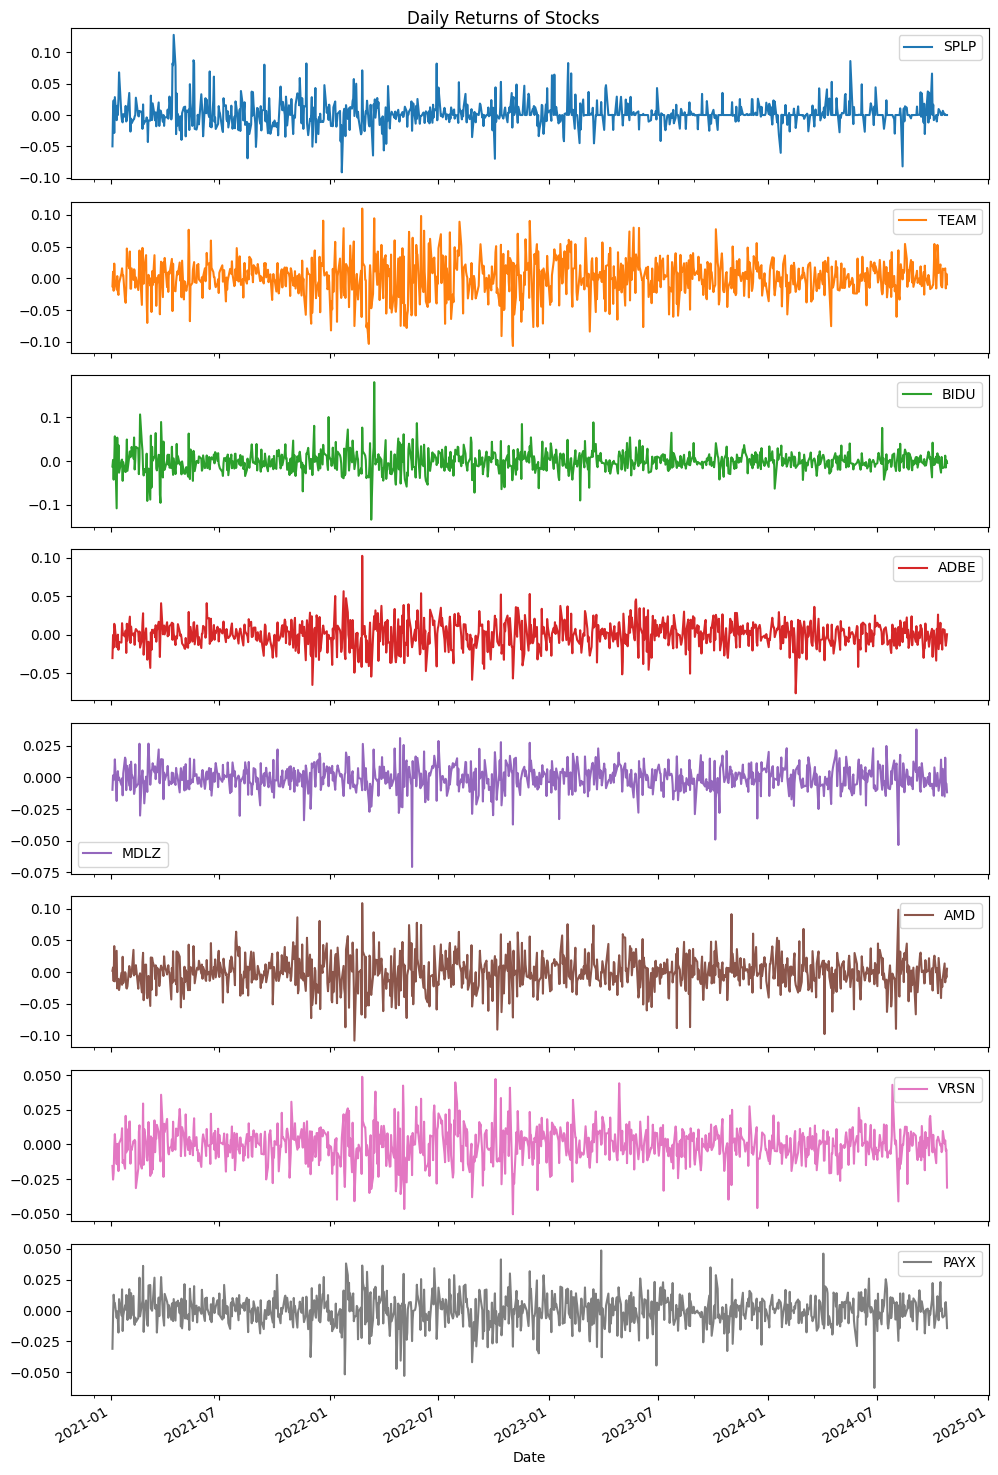

In [136]:
# Plotting daily returns
stock_returns.plot(subplots=True, figsize=(10, 15), title='Daily Returns of Stocks')
plt.tight_layout()
plt.show()

Some of them are showing homoscedascity and low autocovariance, and centered around 0.
#TODO: Mrknout na časové řady cvika a vyjmenovat různé ty vlastnosti a possibly dodělat nějaké grafy

In [137]:
def explore_data(stock_data):
    """
    Explore the downloaded stock data with various analyses.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    print("\n=== Data Exploration ===")
    
    for ticker, df in stock_data.items():
        print(f"\nAnalysis for {ticker}:")
        print("-" * 50)
        
        # Basic info
        print("\nDataset Info:")
        print(df.info())
        
        # Summary statistics
        print("\nSummary Statistics:")
        print(df.describe())
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\nMissing Values:")
            print(missing[missing > 0])
        
        # Calculate daily returns
        df['Daily_Return'] = np.log(df['Close']) - np.log(df['Open'])
        
        # Basic metrics
        print("\nKey Metrics:")
        print(f"Total Trading Days: {len(df)}")
        print(f"Average Daily Volume: {df['Volume'].mean():,.0f}")
        print(f"Average Daily Return: {df['Daily_Return'].mean():.4%}")
        print(f"Return Volatility: {df['Daily_Return'].std():.4%}")
        print(f"Maximum Daily Gain: {df['Daily_Return'].max():.4%}")
        print(f"Maximum Daily Loss: {df['Daily_Return'].min():.4%}")
        
        # Plot price history
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'])
        plt.title(f'{ticker} Stock Price History')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()
        
        # Plot daily returns distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Daily_Return'], kde=True)
        plt.title(f'{ticker} Daily Returns Distribution')
        plt.xlabel('Daily Return')
        plt.ylabel('Frequency')
        plt.show()

In [138]:
all_data['SPLP'] #all data in one frame (disctionary)
#combined_returns #This one is more important

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Daily_Return
0,2021-01-04,10.880000,10.970000,10.250000,10.350000,106400,0.0,0.0,SPLP,-0.049940
1,2021-01-05,10.440000,10.540000,10.300000,10.500000,54000,0.0,0.0,SPLP,0.005731
2,2021-01-06,10.610000,11.540000,10.610000,10.860000,101100,0.0,0.0,SPLP,0.023289
3,2021-01-07,11.010000,11.010000,10.700000,10.700000,45100,0.0,0.0,SPLP,-0.028560
4,2021-01-08,10.700000,11.030000,10.550000,11.010000,51700,0.0,0.0,SPLP,0.028560
...,...,...,...,...,...,...,...,...,...,...
955,2024-10-21,41.250000,41.250000,41.250000,41.250000,300,0.0,0.0,SPLP,0.000000
956,2024-10-22,40.950001,41.000000,40.599998,41.000000,2000,0.0,0.0,SPLP,0.001220
957,2024-10-23,41.000000,41.000000,41.000000,41.000000,0,0.0,0.0,SPLP,0.000000
958,2024-10-24,40.490002,40.490002,40.490002,40.490002,200,0.0,0.0,SPLP,0.000000



=== Data Exploration ===

Analysis for SPLP:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \

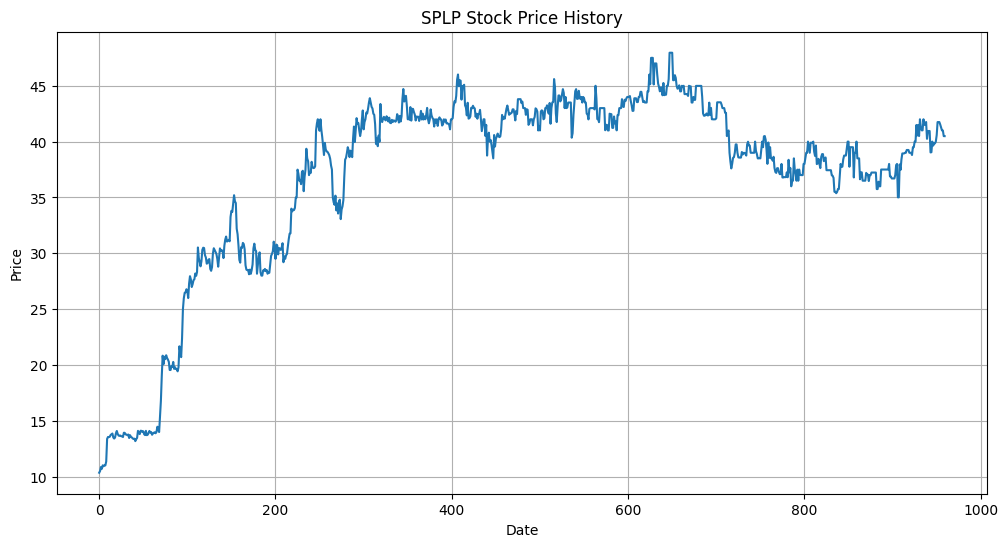

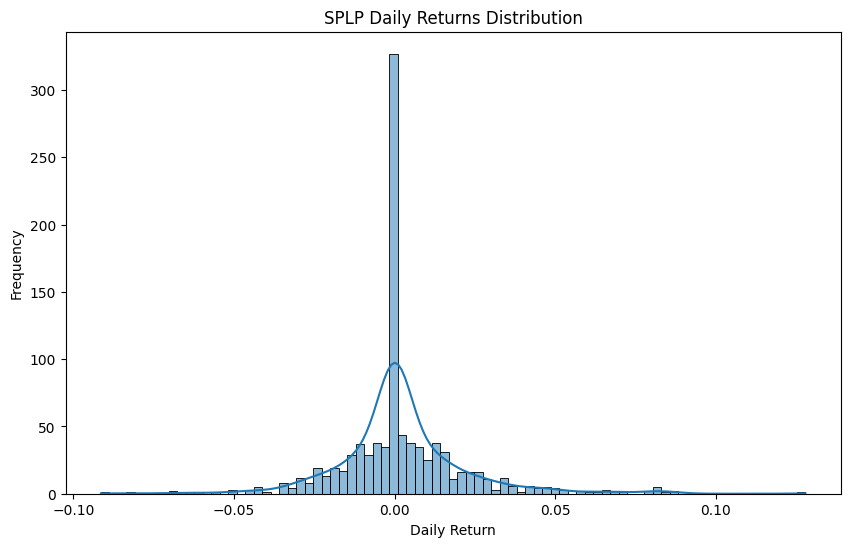


Analysis for TEAM:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

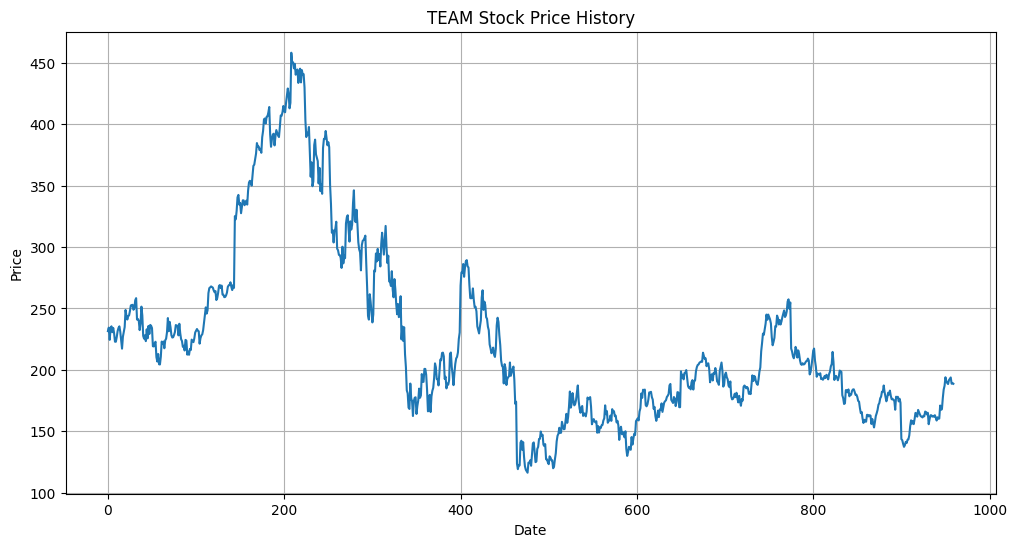

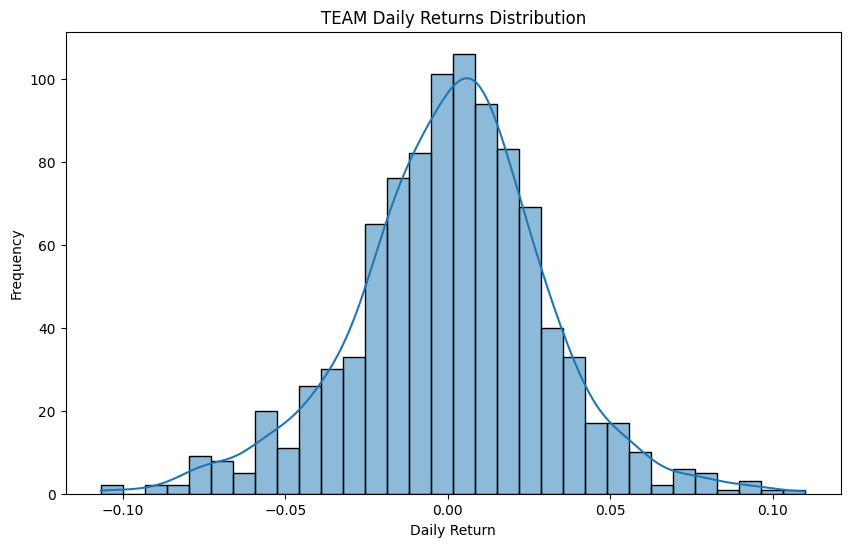


Analysis for BIDU:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

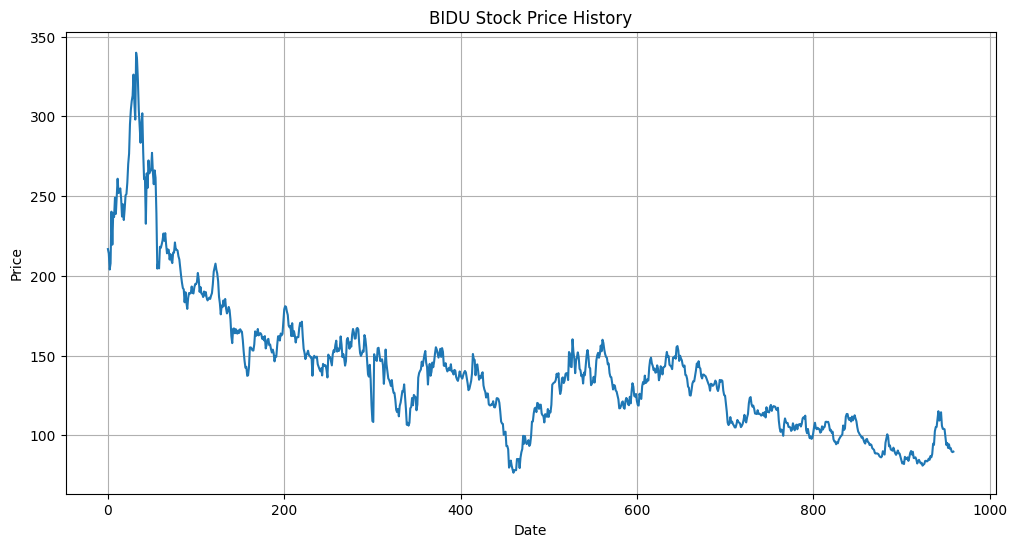

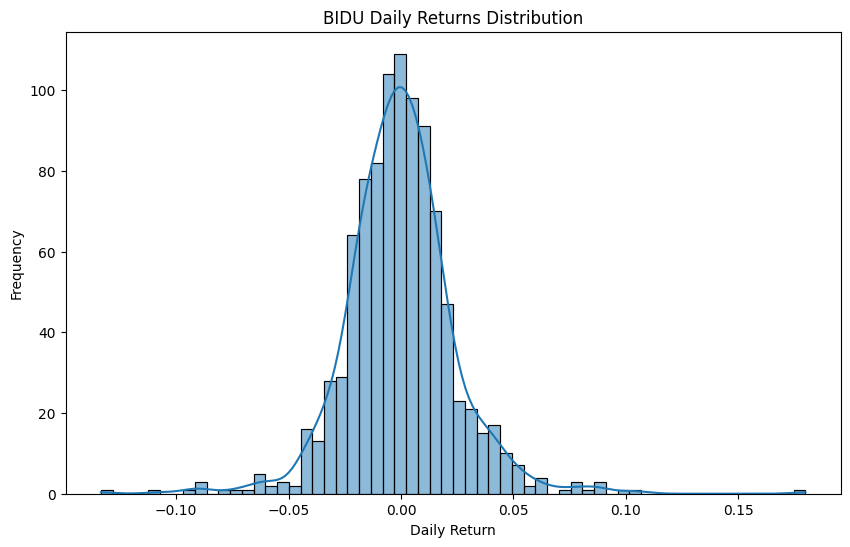


Analysis for ADBE:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

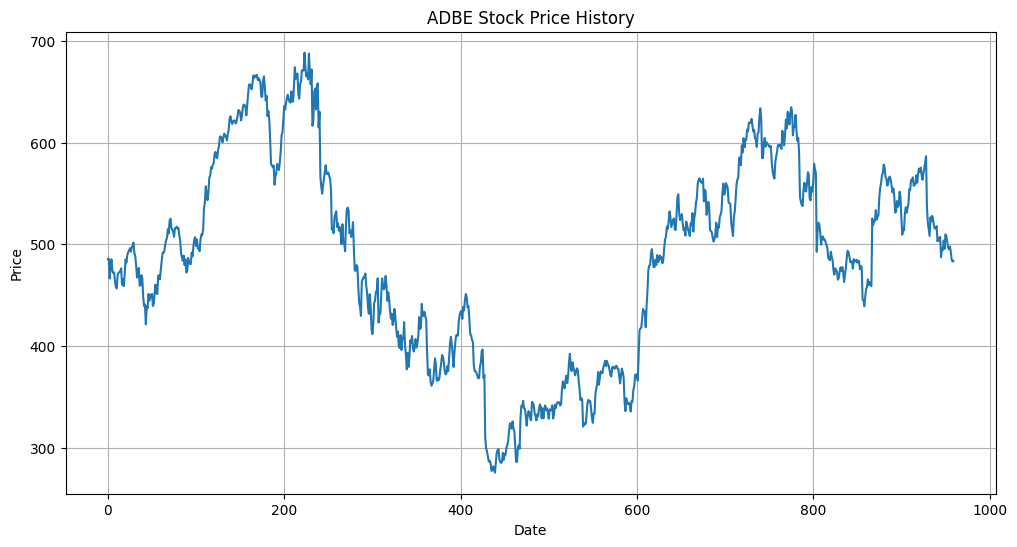

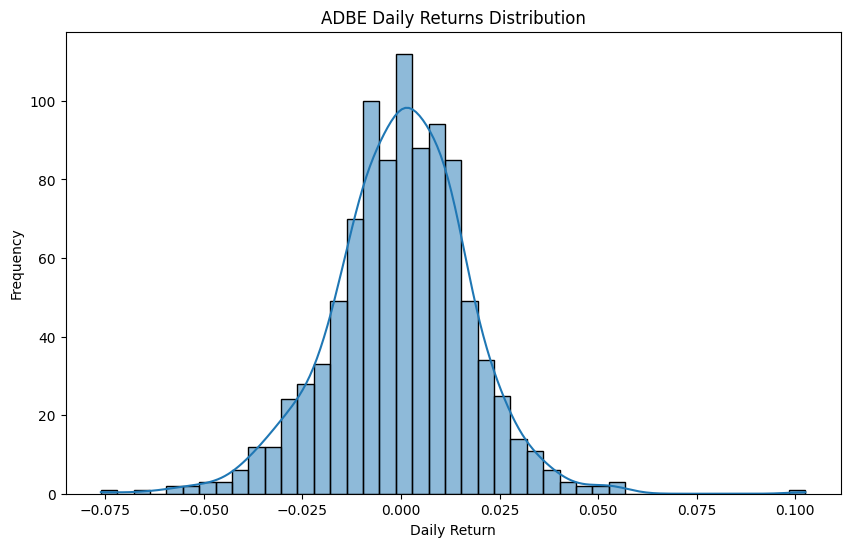


Analysis for MDLZ:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

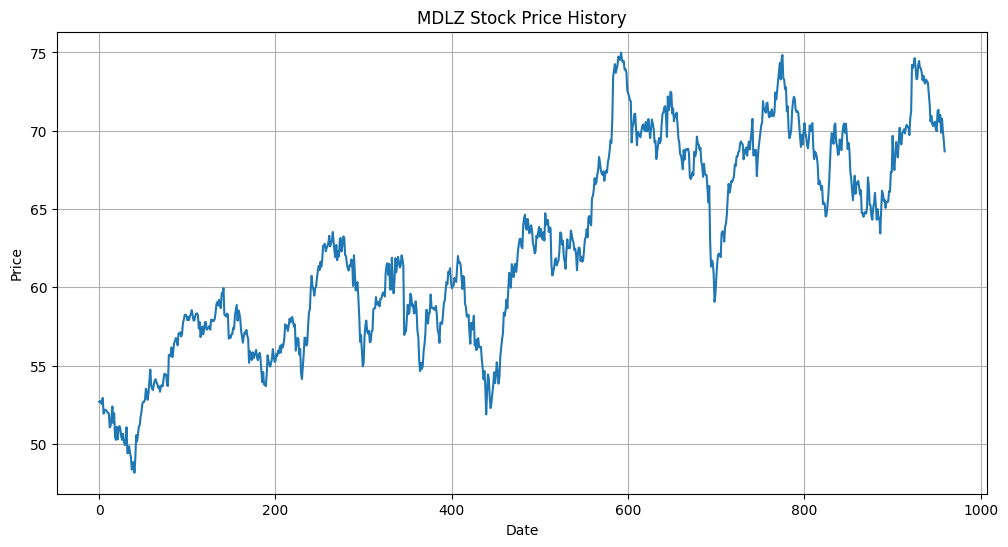

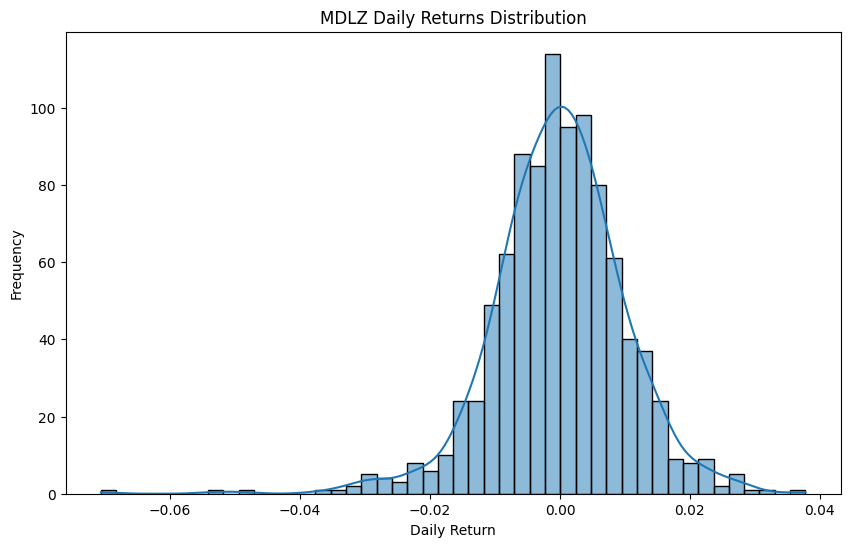


Analysis for AMD:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                     

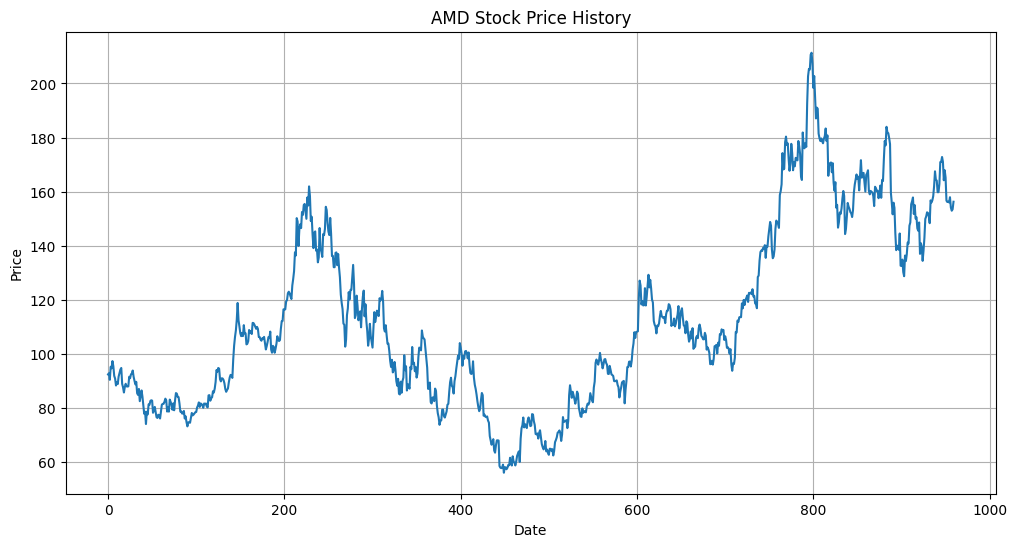

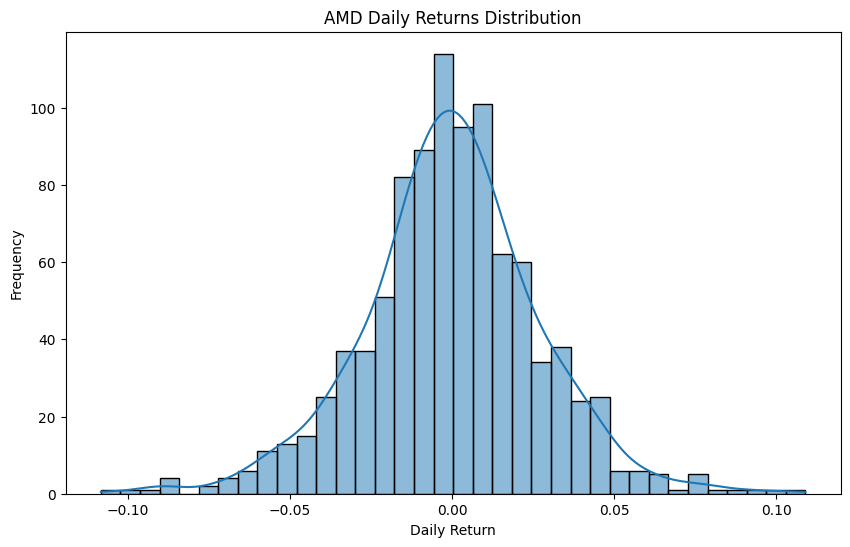


Analysis for VRSN:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

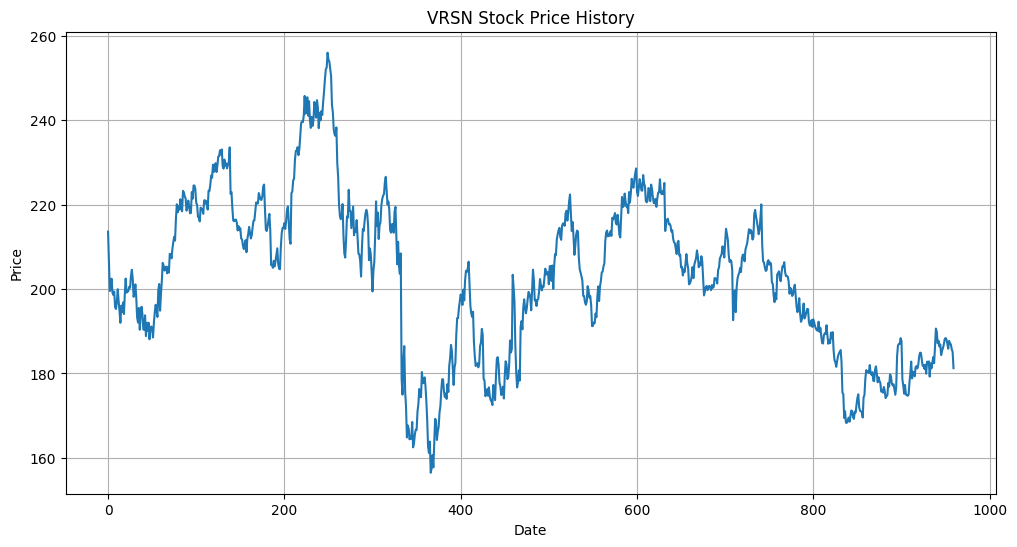

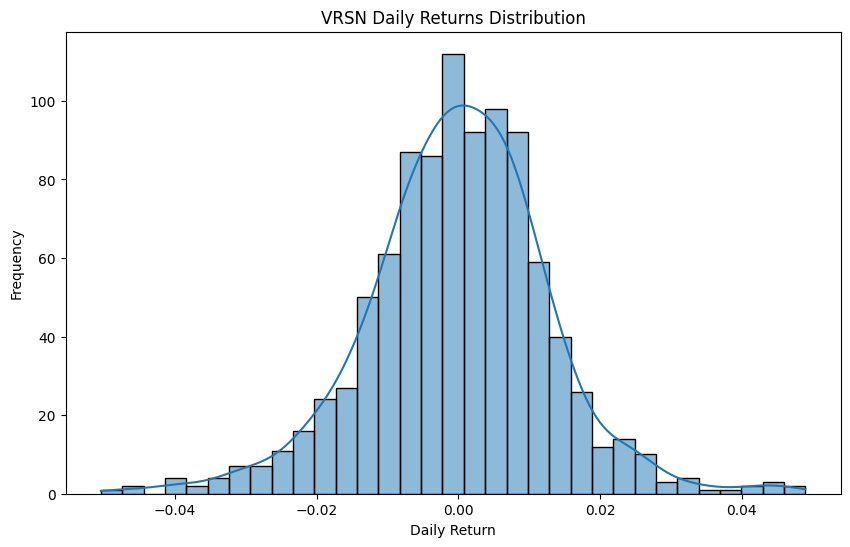


Analysis for PAYX:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

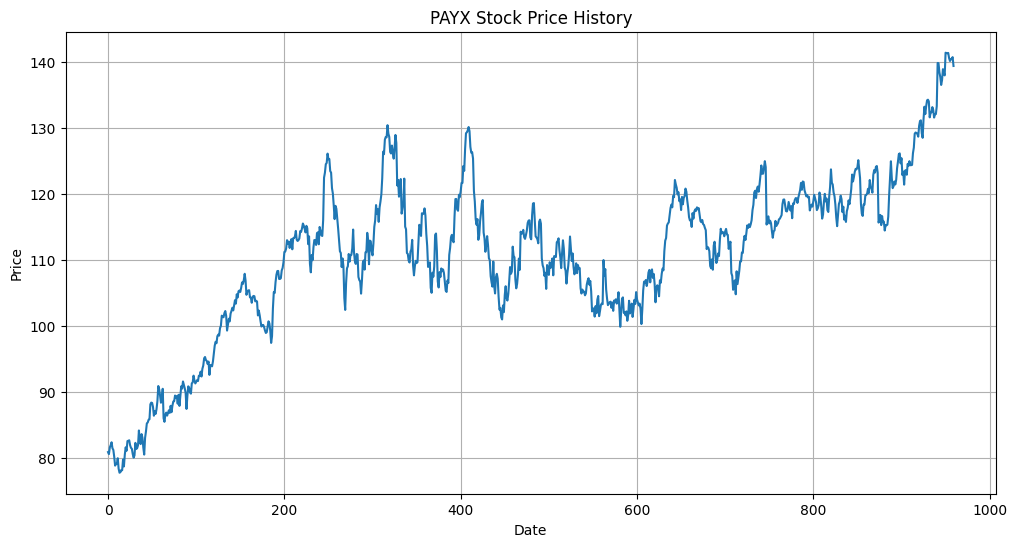

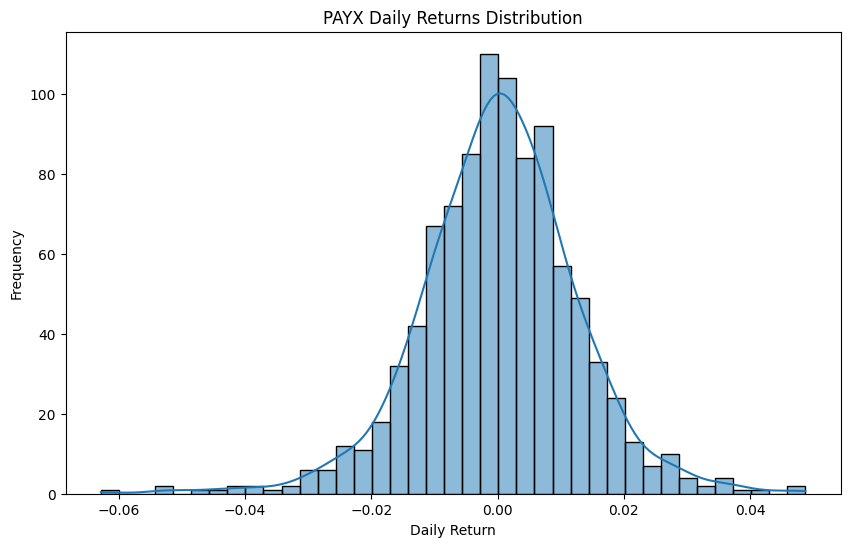

In [139]:
explore_data(all_data)

In [140]:
def plot_stock_data_comparisons(stock_data):
    """
    Plot multiple aspects of stock data for all tickers in the dictionary.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

    # Plot Open Prices
    for ticker, df in stock_data.items():
        axes[0].plot(df.index, df['Open'], label=ticker)
    axes[0].set_title('Open Prices for All Stocks', fontsize=14)
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True)
    
    # Plot Volumes
    for ticker, df in stock_data.items():
        axes[1].plot(df.index, df['Volume'], label=ticker)
    axes[1].set_title('Volumes for All Stocks', fontsize=14)
    axes[1].set_ylabel('Volume')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True)

    # Plot Low-High Range (Confidence Interval)
    for ticker, df in stock_data.items():
        axes[2].fill_between(df.index, df['Low'], df['High'], alpha=0.3, label=ticker)
    axes[2].set_title('Low-High Range for All Stocks', fontsize=14)
    axes[2].set_ylabel('Price Range')
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid(True)

    # Plot Dividends
    for ticker, df in stock_data.items():
        axes[3].plot(df.index, df['Dividends'], label=ticker)
    axes[3].set_title('Dividends for All Stocks', fontsize=14)
    axes[3].set_ylabel('Dividends')
    axes[3].legend(loc='best', fontsize=10)
    axes[3].grid(True)

    # Plot Daily Returns
    for ticker, df in stock_data.items():
        axes[4].plot(df.index, df['Daily_Return'], label=ticker)
    axes[4].set_title('Daily Returns for All Stocks', fontsize=14)
    axes[4].set_ylabel('Daily Return')
    axes[4].legend(loc='best', fontsize=10)
    axes[4].grid(True)

    # Adjust layout and show plot
    plt.xlabel('Date', fontsize=12)
    plt.tight_layout()
    plt.show()


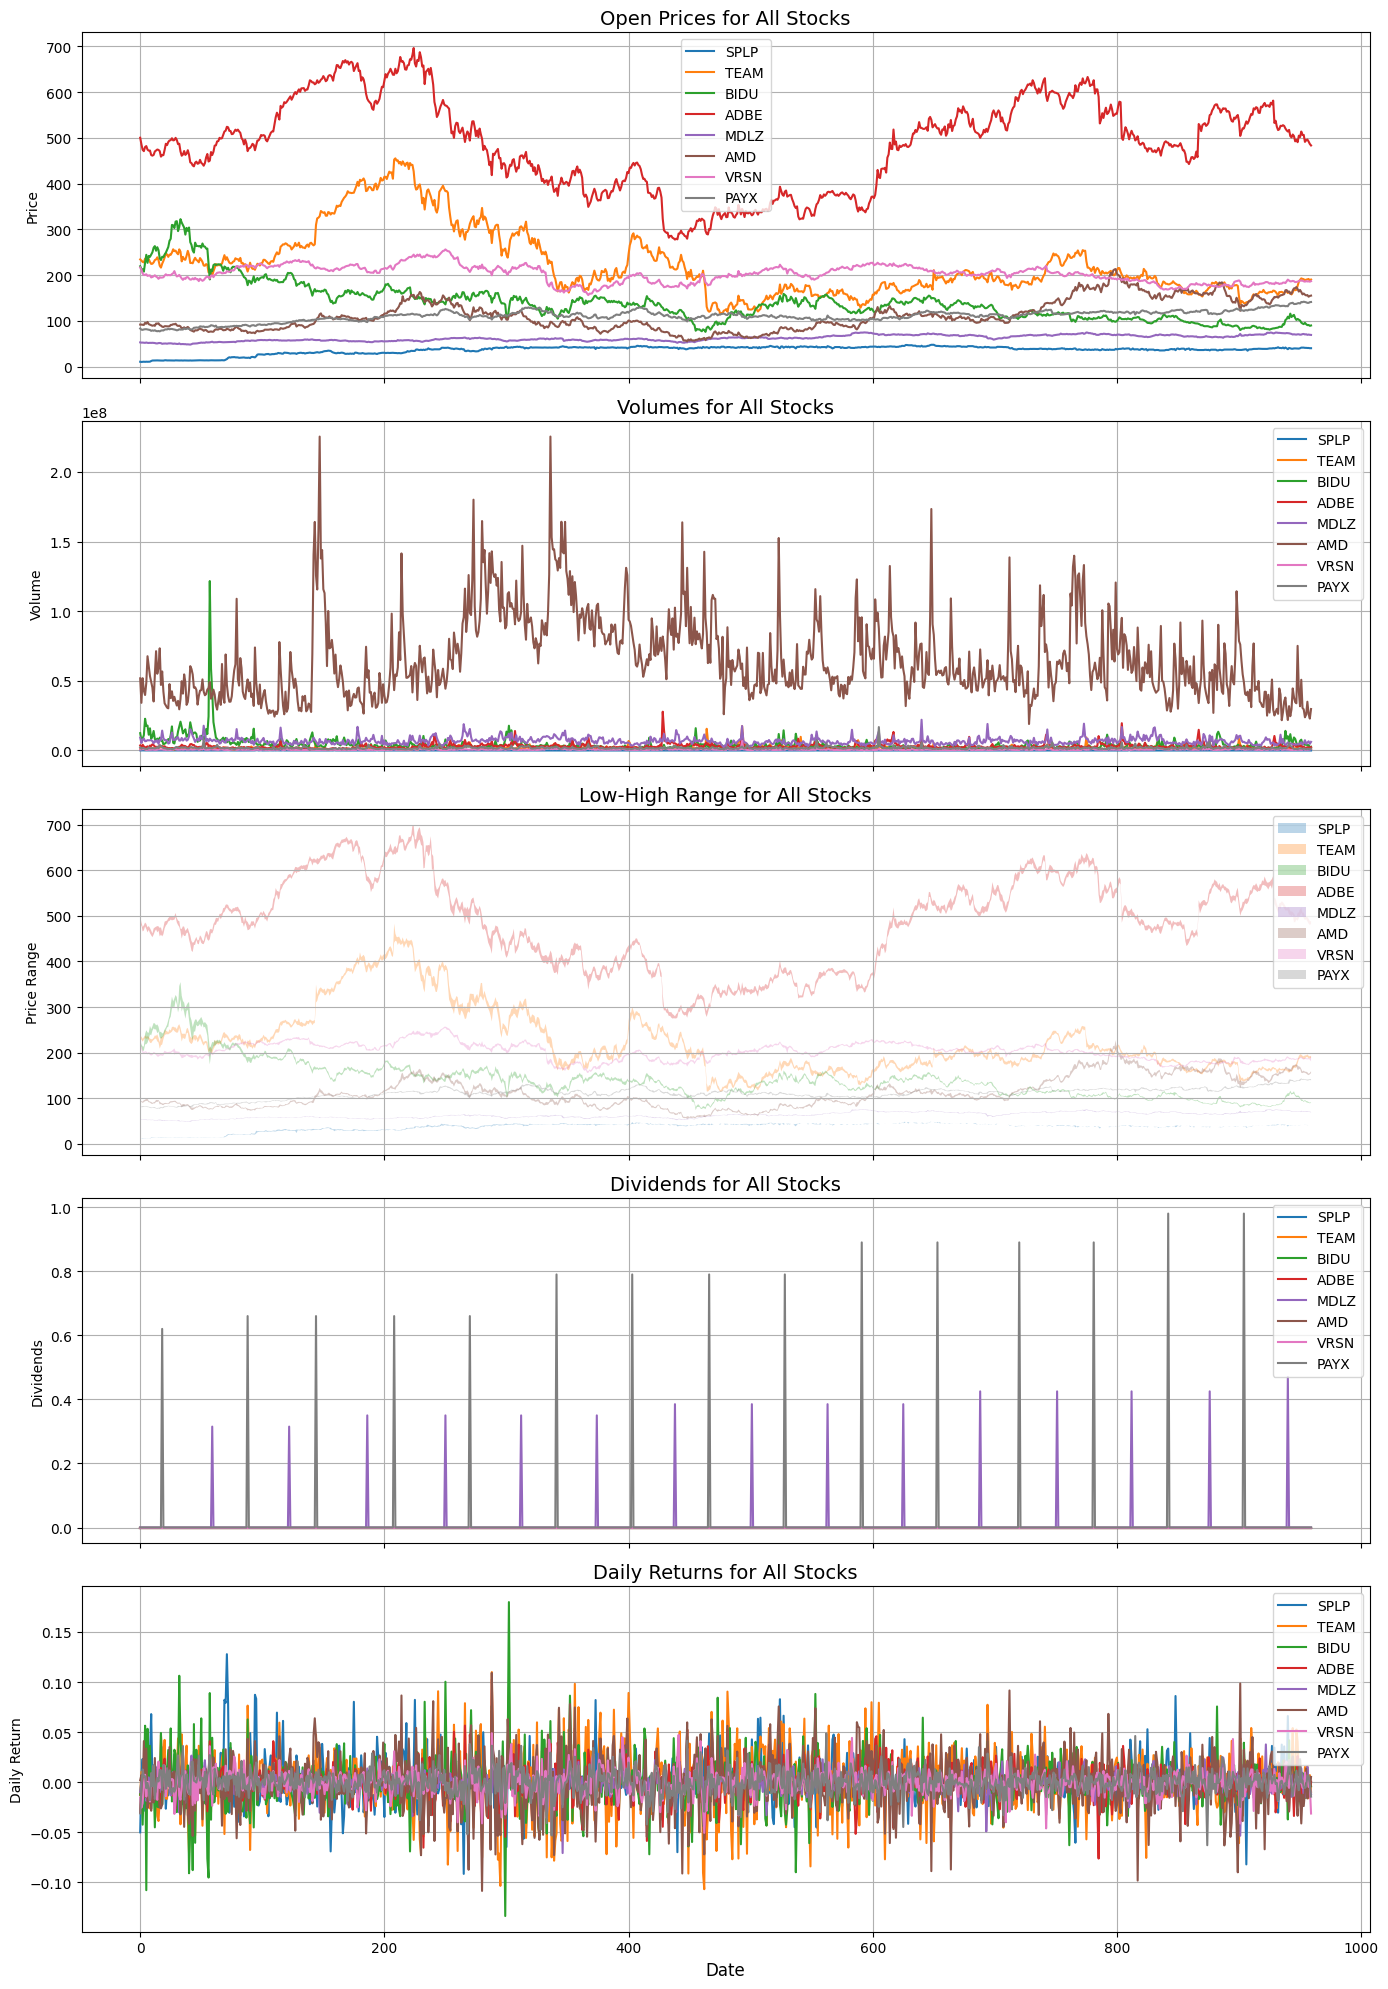

In [141]:
plot_stock_data_comparisons(all_data)

# Efficient Portfolios

In [142]:
START_DATE = '2021-01-01'
END_DATE = '2022-10-24'
YEAR = 252

stock_returns.index = pd.to_datetime(stock_returns.index)
risk_free_rate.index = pd.to_datetime(risk_free_rate.index)

stock_returns_subset = stock_returns[(stock_returns.index >= START_DATE) & 
                                  (stock_returns.index <= END_DATE)]
risk_free_rate_subset = risk_free_rate[(risk_free_rate.index >= START_DATE) & 
                                  (risk_free_rate.index <= END_DATE)]

daily_expected_returns = stock_returns_subset.mean()
yearly_expected_returns = daily_expected_returns*YEAR
covariance_matrix = stock_returns_subset.cov()
yearly_covariance = covariance_matrix*YEAR
daily_risk_free_rate = risk_free_rate_subset['Daily_Rate'].mean()
yearly_risk_free_rate = daily_risk_free_rate*YEAR
assets = len(daily_expected_returns)

In [143]:
def portfolio_values(weights, expected_returns, covariance):
    portfolio_return = np.sum(weights * expected_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    return portfolio_return, std_dev

In [144]:
def min_volatility_weights(target_return, expected_returns, covariance, num_assets, short):
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # sum(weights) = 1
        {"type": "eq", "fun": lambda w: np.sum(w * expected_returns) - target_return}  # return = target return
    )
    #(0,1) w/o short, (-1,1) w/ short
    if short:
        bounds = tuple((-1, 1) for _ in range(num_assets))
    else:
        bounds = tuple((0, 1) for _ in range(num_assets)) 
    
    weights = minimize(
        fun=lambda w: portfolio_values(w, expected_returns, covariance)[1],
        x0=num_assets * [1 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if not weights.success:
        raise ValueError("Error: Could not get weigts.")
    
    return weights.x

In [145]:
# Generate efficient frontier points without short selling
target_returns = np.linspace(yearly_expected_returns.min(), yearly_expected_returns.max(), 100)
frontier_returns = []
frontier_risks = []

for target_return in target_returns:
    weights = min_volatility_weights(target_return, yearly_expected_returns, yearly_covariance, assets, False)
    ret, risk = portfolio_values(weights, yearly_expected_returns, yearly_covariance)
    frontier_returns.append(ret)
    frontier_risks.append(risk)

# Calculate Capital Market Line
max_sharpe_index = np.argmax([ (ret - yearly_risk_free_rate) / risk for ret, risk in zip(frontier_returns, frontier_risks)])

tangency_return = frontier_returns[max_sharpe_index]
tangency_risk = frontier_risks[max_sharpe_index]
tangency_weights = min_volatility_weights(tangency_return, yearly_expected_returns, yearly_covariance, assets, False)

# Slope of the Capital Market Line (CML)
slope_cml = (tangency_return - yearly_risk_free_rate) / tangency_risk

# Calculate x_cml and y_cml (Capital Market Line)
x_cml = np.linspace(0, max(frontier_risks), 100)
y_cml = yearly_risk_free_rate + slope_cml * x_cml
print(tangency_weights)

[6.4381e-01 0.0000e+00 1.5266e-16 0.0000e+00 7.6328e-17 0.0000e+00
 1.0408e-17 3.5619e-01]


In [146]:
# Generate efficient frontier points with short selling
target_returns_s = np.linspace(yearly_expected_returns.min(), yearly_expected_returns.max()*2.5, 100)
frontier_returns_s = []
frontier_risks_s = []

for target_return in target_returns_s:
    weights = min_volatility_weights(target_return, yearly_expected_returns, yearly_covariance, assets, True)
    ret, risk = portfolio_values(weights, yearly_expected_returns, yearly_covariance)
    frontier_returns_s.append(ret)
    frontier_risks_s.append(risk)

# Calculate Capital Market Line
max_sharpe_index_s = np.argmax([ (ret - yearly_risk_free_rate) / risk for ret, risk in zip(frontier_returns_s, frontier_risks_s)])

tangency_return_s = frontier_returns_s[max_sharpe_index_s]
tangency_risk_s = frontier_risks_s[max_sharpe_index_s]
tangency_weights_s = min_volatility_weights(tangency_return_s, yearly_expected_returns, yearly_covariance, assets, True)

# Slope of the Capital Market Line (CML)
slope_cml_s = (tangency_return_s - yearly_risk_free_rate) / tangency_risk_s

# Calculate x_cml and y_cml (Capital Market Line)
x_cml_s = np.linspace(0, max(frontier_risks_s), 100)
y_cml_s = yearly_risk_free_rate + slope_cml_s * x_cml_s
print(tangency_weights_s)

[ 0.9803  0.5067 -0.1927 -0.9376 -0.3687 -0.5888  0.6008  1.    ]


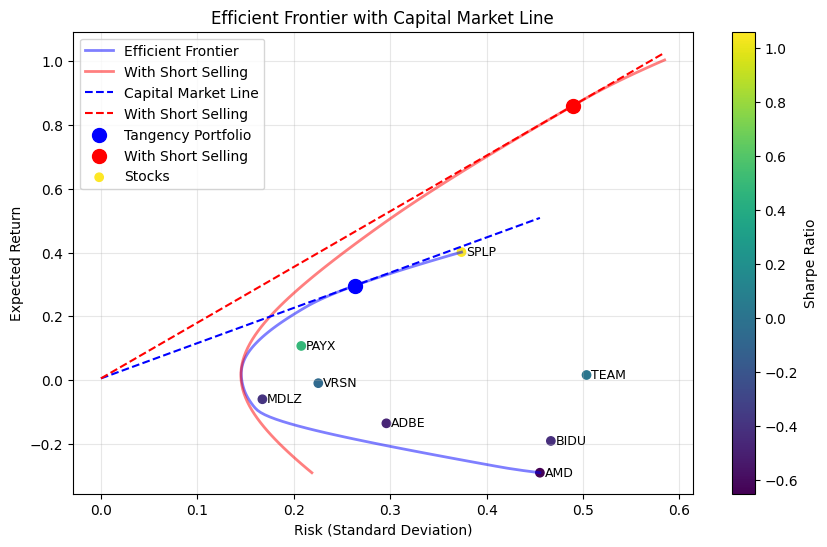

In [147]:
# Create a plot
plt.figure(figsize=(10, 6))


# Plot efficient frontier
plt.plot(frontier_risks, frontier_returns, 
        color='blue', 
        linewidth=2, 
        alpha = 0.5, 
        label='Efficient Frontier')
plt.plot(frontier_risks_s, frontier_returns_s, 
        color='red', 
        linewidth=2, 
        alpha = 0.5,
        label='With Short Selling')

# Plot CML
plt.plot(x_cml, y_cml, 
color='blue', 
        linestyle='--', 
        label='Capital Market Line')
plt.plot(x_cml_s, y_cml_s, 
color='red', 
        linestyle='--',
        label='With Short Selling')

# Plot tangency portfolio
plt.scatter(tangency_risk, tangency_return, 
          color='blue', 
          marker='o', 
          s=100, 
          label='Tangency Portfolio')
plt.scatter(tangency_risk_s, tangency_return_s, 
          color='red', 
          marker='o', 
          s=100, 
          label='With Short Selling')

# Plot individual assets (stocks)
tickers = list(STOCK_FILES.keys())
# Calculate risks and returns for all stocks
risks = np.sqrt(np.diag(yearly_covariance))  # Standard deviation
returns = yearly_expected_returns  # Annualized returns
sratios = (returns - yearly_risk_free_rate) / risks #Sharpe ratios

# Plot all stocks in one scatter call
scatter = plt.scatter(risks, returns, 
                      c=sratios, 
                      alpha=1, 
                      label='Stocks')

# Add tickers as text annotations
for i, ticker in enumerate(tickers):
    plt.text(risks[i]+0.005, returns[i], 
             ticker, 
             fontsize=9, 
             ha='left', 
             va='center')
    
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

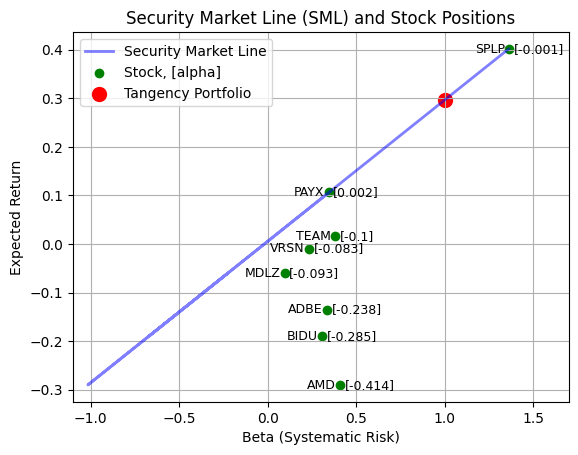

In [148]:
beta_sml = (yearly_expected_returns - yearly_risk_free_rate) / (tangency_return - yearly_risk_free_rate)

# Compute the SML
betas_sml = np.linspace(0, 2, 100)  # Beta range for the SML
sml_returns = yearly_risk_free_rate + betas_sml * (tangency_return - yearly_risk_free_rate)

daily_tangency_returns = stock_returns_subset.values @ tangency_weights
y = (stock_returns_subset.subtract(risk_free_rate_subset['Daily_Rate'],axis=0))*YEAR
x = (daily_tangency_returns - risk_free_rate_subset['Daily_Rate'])*YEAR
x = sm.add_constant(x)

alphas = []
betas = []
for ticker in tickers:
    model = sm.OLS(y[ticker].values,x).fit()
    alpha, beta = model.params
    alphas.append(alpha)
    betas.append(beta)

returns = np.array(alphas) + yearly_risk_free_rate + np.array(betas) * (tangency_return - yearly_risk_free_rate)
#print(betas, alphas)

# # Plot the SML
plt.plot(beta_sml, yearly_expected_returns, label="Security Market Line", color='blue', linewidth=2, alpha=0.5)
plt.scatter(np.array(betas), returns, label='Stock, [alpha]', color='green')
for i, ticker in enumerate(tickers):
    plt.text(np.array(betas)[i]-0.025, returns[i], 
             ticker, 
             fontsize=9, 
             ha='right', 
             va='center')
    a=str([np.round(alphas[i], 3)])
    plt.text(np.array(betas)[i]+0.025, returns[i], 
             a,
             fontsize=9, 
             ha='left', 
             va='center')

plt.scatter(1, tangency_return, 
          color='red', 
          marker='o', 
          s=100, 
          label='Tangency Portfolio')

# # Labels and title
plt.xlim(-1.1, 1.7)
plt.title("Security Market Line (SML) and Stock Positions")
plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# The Markowitz Model

We have choosen strategy of min risk, min expected returns = 6 % p.a, the historical/empirical data was used.

#TODO: Try different estimation methods

In [149]:
YEAR=252
MIN_Y_RETURN = 0.1
MIN_D_RETURN = MIN_Y_RETURN/YEAR
SHORT=True

daily_expected_returns = stock_returns.mean()
yearly_expected_returns = daily_expected_returns*YEAR
daily_covariance_matrix = stock_returns.cov()
yearly_covariance_matrix = daily_covariance_matrix*YEAR
daily_risk_free_rate = risk_free_rate['Daily_Rate'].mean()
yearly_risk_free_rate = daily_risk_free_rate*YEAR
assets = len(daily_expected_returns)

In [150]:
def historical_mean_return_variance(date, stock_returns, risk_free_rate, year):
    target_date = pd.Timestamp(date)
    one_year_before = target_date - pd.DateOffset(years=1)
    start_date = stock_returns.index[stock_returns.index >= one_year_before][0]
    end_date = stock_returns.index[stock_returns.index < target_date][-1]
    
    stock_returns_subset = stock_returns[(stock_returns.index >= start_date) & 
                                  (stock_returns.index <= end_date)]
    risk_free_rate_subset = risk_free_rate[(risk_free_rate.index >= start_date) & 
                                  (risk_free_rate.index <= end_date)]
    
    daily_expected_returns = stock_returns_subset.mean()
    yearly_expected_returns = daily_expected_returns*year
    covariance_matrix = stock_returns_subset.cov()
    yearly_covariance = covariance_matrix*year
    daily_risk_free_rate = risk_free_rate_subset['Daily_Rate'].mean()
    yearly_risk_free_rate = daily_risk_free_rate*year
    assets = len(daily_expected_returns)

    return yearly_expected_returns, yearly_covariance, yearly_risk_free_rate, assets

In [151]:
def ewma_return_variance(date, stock_returns, risk_free_rate, year):
    lambda_=0.94
    target_date = pd.Timestamp(date)
    one_year_before = target_date - pd.DateOffset(years=1)
    start_date = stock_returns.index[stock_returns.index >= one_year_before][0]
    end_date = stock_returns.index[stock_returns.index < target_date][-1]

    stock_returns_subset = stock_returns[(stock_returns.index >= start_date) & 
                                         (stock_returns.index <= end_date)]
    risk_free_rate_subset = risk_free_rate[(risk_free_rate.index >= start_date) & 
                                           (risk_free_rate.index <= end_date)]
    
    n = len(stock_returns_subset)
    weights = (1 - lambda_) * lambda_ ** (n - 1 - np.arange(n))
    weights /= weights.sum()
    
    daily_expected_returns = (weights[:, None] * stock_returns_subset).sum(axis=0)
    yearly_expected_returns = daily_expected_returns * year

    demeaned_returns = stock_returns_subset - stock_returns_subset.mean()
    weighted_cov = np.zeros((len(stock_returns.columns), len(stock_returns.columns)))
    for i, (index, row) in enumerate(demeaned_returns.iterrows()):
        weighted_cov += weights[i] * np.outer(row, row)
    yearly_covariance = weighted_cov * year

    ewma_risk_free_rate = (weights * risk_free_rate_subset['Daily_Rate']).sum()
    yearly_risk_free_rate = ewma_risk_free_rate * year

    assets = len(daily_expected_returns)

    return yearly_expected_returns, yearly_covariance, yearly_risk_free_rate, assets

In [152]:
def calculate_minimum_risk_portfolio(min, expected_returns, covariance, assets, rfr, short):
    returns = expected_returns - rfr

    initial_weights = np.ones(assets)/assets
    constraints = [
        {'type': 'ineq', 'fun': lambda w:  np.dot(w, returns) + rfr - min}
    ]
    if short: lb=-1
    else: lb=0
    bounds = [(lb, 1) for i in range(assets)]
    
    def portfolio_risk(w):
        return 0.5 * np.dot(w.T, np.dot(covariance, w))
    
    Mark = minimize(fun=lambda w: portfolio_risk(w), x0=initial_weights, constraints=constraints, bounds=bounds)
    
    # Portfolio weights, risk, and return
    weights = Mark.x
    rfw = 1-np.sum(weights)
    portfolio_return = np.dot(weights, expected_returns) + rfw*rfr
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    
    return {
        'weights': weights,
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk,
        'risk_free_weight': rfw
    }

In [153]:
Markowitz_port = calculate_minimum_risk_portfolio(MIN_Y_RETURN, yearly_expected_returns, yearly_covariance_matrix, assets, yearly_risk_free_rate, SHORT)
Markowitz_without_s = calculate_minimum_risk_portfolio(MIN_Y_RETURN, yearly_expected_returns, yearly_covariance_matrix, assets, yearly_risk_free_rate, False)

In [154]:
target_returns = np.linspace(yearly_expected_returns.min(), yearly_expected_returns.max(), 100)
frontier_returns = []
frontier_risks = []

for target_return in target_returns:
    weights = min_volatility_weights(target_return, yearly_expected_returns, yearly_covariance_matrix, assets, False)
    ret, risk = portfolio_values(weights, yearly_expected_returns, yearly_covariance_matrix)
    frontier_returns.append(ret)
    frontier_risks.append(risk)

# Calculate Capital Market Line
max_sharpe_index = np.argmax([ (ret - yearly_risk_free_rate) / risk for ret, risk in zip(frontier_returns, frontier_risks)])

tangency_return = frontier_returns[max_sharpe_index]
tangency_risk = frontier_risks[max_sharpe_index]
#tangency_weights = min_volatility_weights(tangency_return, yearly_expected_returns, yearly_covariance_matrix, assets, False)

target_returns_s = np.linspace(yearly_expected_returns.min(), yearly_expected_returns.max()*1.5, 100)
frontier_returns_s = []
frontier_risks_s = []

for target_return in target_returns_s:
    weights = min_volatility_weights(target_return, yearly_expected_returns, yearly_covariance_matrix, assets, True)
    ret, risk = portfolio_values(weights, yearly_expected_returns, yearly_covariance_matrix)
    frontier_returns_s.append(ret)
    frontier_risks_s.append(risk)

# Calculate Capital Market Line
max_sharpe_index_s = np.argmax([ (ret - yearly_risk_free_rate) / risk for ret, risk in zip(frontier_returns_s, frontier_risks_s)])

tangency_return_s = frontier_returns_s[max_sharpe_index_s]
tangency_risk_s = frontier_risks_s[max_sharpe_index_s]
#tangency_weights_s = min_volatility_weights(tangency_return_s, yearly_expected_returns, yearly_covariance_matrix, assets, True)

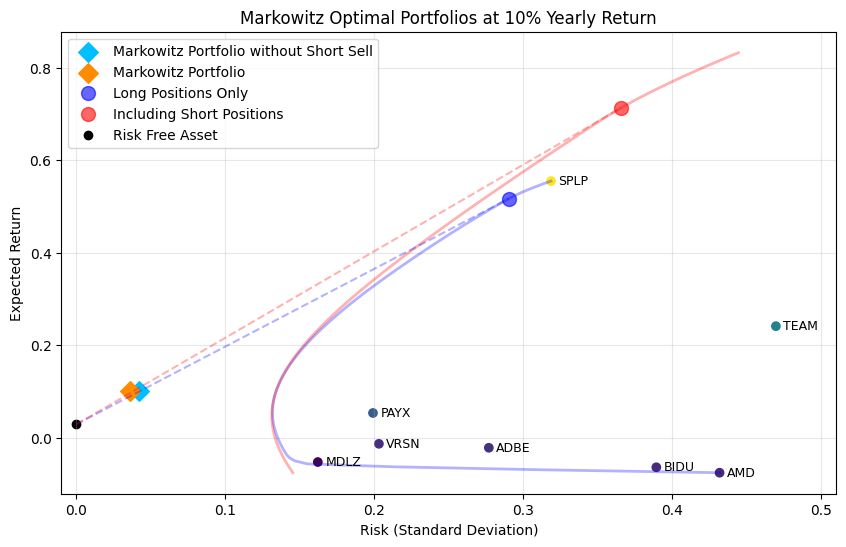

In [155]:
plt.figure(figsize=(10, 6))

# Get Markowitz results and add to plot
markowitz_risk = Markowitz_port['portfolio_risk']
markowitz_return = Markowitz_port['portfolio_return']

long_risk = Markowitz_without_s['portfolio_risk']
long_return = Markowitz_without_s['portfolio_return']

# Plot Markowitz optimal portfolio
plt.scatter(long_risk, long_return,
           color='deepskyblue',
           marker='D',
           s=100,
           label='Markowitz Portfolio without Short Sell')
plt.scatter(markowitz_risk, markowitz_return,
           color='darkorange',
           marker='D',
           s=100,
           label='Markowitz Portfolio')

plt.plot(frontier_risks, frontier_returns, 
        color='blue', 
        linewidth=2, 
        alpha = 0.3)
plt.scatter(tangency_risk, tangency_return, 
          color='blue', 
          marker='o', 
          s=100, 
          label='Long Positions Only', 
        alpha = 0.6)
plt.plot(frontier_risks_s, frontier_returns_s, 
        color='red', 
        linewidth=2, 
        alpha = 0.3)
plt.scatter(tangency_risk_s, tangency_return_s, 
          color='red', 
          marker='o', 
          s=100, 
          label='Including Short Positions', 
        alpha = 0.6)

plt.scatter(0, yearly_risk_free_rate,
            color='black',
            label='Risk Free Asset')

# Plot individual assets (stocks)
tickers = list(STOCK_FILES.keys())
# Calculate risks and returns for all stocks
risks = np.sqrt(np.diag(yearly_covariance_matrix))  # Standard deviation
returns = yearly_expected_returns  # Annualized returns
sratios = (returns - yearly_risk_free_rate) / risks #Sharpe ratios

# Plot all stocks in one scatter call
scatter = plt.scatter(risks, returns, 
                      c=sratios, 
                      alpha=1)

# Add tickers as text annotations
for i, ticker in enumerate(tickers):
    plt.text(risks[i]+0.005, returns[i], 
             ticker, 
             fontsize=9, 
             ha='left', 
             va='center')
    
plt.plot([0, tangency_risk], [yearly_risk_free_rate, tangency_return],
         color='blue', 
         linestyle='--', 
        alpha = 0.3)
plt.plot([0, tangency_risk_s], [yearly_risk_free_rate, tangency_return_s],
         color='red', 
         linestyle='--', 
        alpha = 0.3)

plt.xlim(-0.01, 0.51)
#plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title(f'Markowitz Optimal Portfolios at {MIN_Y_RETURN:.0%} Yearly Return')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [156]:
# Print optimal portfolio weights and performance
np.set_printoptions(precision=4)
print("With short positions allowed:")
print("Optimal Portfolio Weights:", Markowitz_port['weights'])
print("Risk-free Asset Weight:", "{:.4f}".format(Markowitz_port['risk_free_weight']))
print("Portfolio Expected Yearly Return:", "{:.2f}".format(100*Markowitz_port['portfolio_return']), "%")
print("Portfolio Risk (Std Dev):", "{:.4f}".format(Markowitz_port['portfolio_risk']))
#print(sum(Markowitz_port['weights'])+Markowitz_port['risk_free_weight'])
print("Only long positions allowed:")
print("Optimal Portfolio Weights:", np.round(Markowitz_without_s['weights'],4))
print("Risk-free Asset Weight:", "{:.4f}".format(Markowitz_without_s['risk_free_weight']))
print("Portfolio Expected Yearly Return:", "{:.2f}".format(100*Markowitz_without_s['portfolio_return']), "%")
print("Portfolio Risk (Std Dev):", "{:.4f}".format(Markowitz_without_s['portfolio_risk']))

With short positions allowed:
Optimal Portfolio Weights: [ 0.0984  0.0384 -0.0179 -0.0235 -0.0523 -0.0223 -0.0286  0.0238]
Risk-free Asset Weight: 0.9840
Portfolio Expected Yearly Return: 10.00 %
Portfolio Risk (Std Dev): 0.0363
Only long positions allowed:
Optimal Portfolio Weights: [0.1287 0.0161 0.     0.     0.     0.     0.     0.    ]
Risk-free Asset Weight: 0.8552
Portfolio Expected Yearly Return: 10.00 %
Portfolio Risk (Std Dev): 0.0423


In [157]:
# Data setup
data = {
    "Portfolio Type": ["Short Positions Allowed", "Long Positions Only"],
    **{ticker: [Markowitz_port['weights'][i], Markowitz_without_s['weights'][i]] for i, ticker in enumerate(tickers)},
    "Risk-free Asset": [Markowitz_port['risk_free_weight'], Markowitz_without_s['risk_free_weight']],
    "Expected Yearly Return (%)": [100 * Markowitz_port['portfolio_return'], 100 * Markowitz_without_s['portfolio_return']],
    "Portfolio Risk (Std Dev)": [Markowitz_port['portfolio_risk'], Markowitz_without_s['portfolio_risk']],
}

# Create the DataFrame
portfolio_df = pd.DataFrame(data)

portfolio_df = portfolio_df.copy()  # Avoid modifying the original DataFrame
for col in portfolio_df.columns[1:]:
    portfolio_df[col] = portfolio_df[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

# Convert the DataFrame to a table
print(tabulate(portfolio_df, headers="keys", tablefmt="plain", showindex=False))

Portfolio Type             SPLP    TEAM     BIDU     ADBE     MDLZ      AMD     VRSN    PAYX    Risk-free Asset    Expected Yearly Return (%)    Portfolio Risk (Std Dev)
Short Positions Allowed  0.0984  0.0384  -0.0179  -0.0235  -0.0523  -0.0223  -0.0286  0.0238             0.984                             10                      0.0363
Long Positions Only      0.1287  0.0161   0        0        0        0        0       0                  0.8552                            10                      0.0423


# Out-Of-Sample Investing

In [158]:
def simulate_investment(stock_returns, risk_free_rate, start_date, end_date, 
                        initial_capital, min_return, calculate_minimum_risk_portfolio, 
                        return_variance_func, tangency_weights, tangency_weights_s, short=False):
    """
    Simulates investment over time using an optimal portfolio strategy.
    
    Parameters:
        stock_returns (pd.DataFrame): DataFrame of stock daily returns, indexed by date.
        risk_free_rate (pd.DataFrame): DataFrame of daily risk-free rates, indexed by date.
        start_date (str): Start date of the simulation (inclusive).
        end_date (str): End date of the simulation (inclusive).
        initial_capital (float): Initial investment capital.
        min_return (float): Minimum return required for the portfolio.
        calculate_minimum_risk_portfolio (function): Function to calculate optimal portfolio weights.
        short (bool): Whether to allow short positions in the portfolio.

    Returns:
        portfolio_values (pd.Series): Series of portfolio values over time.
    """
    # Initialize variables
    portfolio_values = []
    equal_weight_values = []
    tangency_values = []
    
    capital = initial_capital
    capital_equal_weight = initial_capital
    capital_tangency = initial_capital
    
    trading_days = stock_returns.index[(stock_returns.index >= start_date) & (stock_returns.index <= end_date)]
    yearly_expected_returns, yearly_covariance, yearly_risk_free_rate, assets = return_variance_func(
            trading_days[0], stock_returns, risk_free_rate, year=252)
    equal_weights = np.ones(assets) / assets
    tangency_weights_used = tangency_weights if not short else tangency_weights_s
    
    for current_date in trading_days:  # Exclude the last trading day
        # Calculate expected returns, covariance, and risk-free rate up to the current date
        yearly_expected_returns, yearly_covariance, yearly_risk_free_rate, assets = return_variance_func(
            current_date, stock_returns, risk_free_rate, year=252
        )
        
        # Calculate optimal portfolio weights and other metrics
        portfolio_result = calculate_minimum_risk_portfolio(
            min_return, yearly_expected_returns, yearly_covariance, assets, yearly_risk_free_rate, short
        )
        weights = portfolio_result['weights']
        risk_free_weight = portfolio_result['risk_free_weight']
        
        # Get the returns for the current trading day
        current_day_returns = stock_returns.loc[current_date]
        
        # Get the actual risk-free rate for the current day
        actual_risk_free_rate = risk_free_rate.loc[current_date, 'Daily_Rate']
        
        # Calculate portfolio return (including risk-free weight)
        portfolio_return = np.dot(weights, current_day_returns.values) + risk_free_weight * actual_risk_free_rate
        
        # Update capital
        capital *= (1 + portfolio_return)
        portfolio_values.append((current_date, capital))

        # Equal-Weights Portfolio
        equal_weight_return = np.dot(equal_weights, current_day_returns.values)
        capital_equal_weight *= (1 + equal_weight_return)
        equal_weight_values.append((current_date, capital_equal_weight))
        
        # Tangency Portfolio
        tangency_return = np.dot(tangency_weights_used, current_day_returns.values)
        capital_tangency *= (1 + tangency_return)
        tangency_values.append((current_date, capital_tangency))
    
    results = pd.DataFrame({
        'Markowitz Portfolio': [value for _, value in portfolio_values],
        'Equal Weights Portfolio': [value for _, value in equal_weight_values],
        'Tangency Portfolio': [value for _, value in tangency_values]
    }, index=[date for date, _ in portfolio_values])
    
    return results

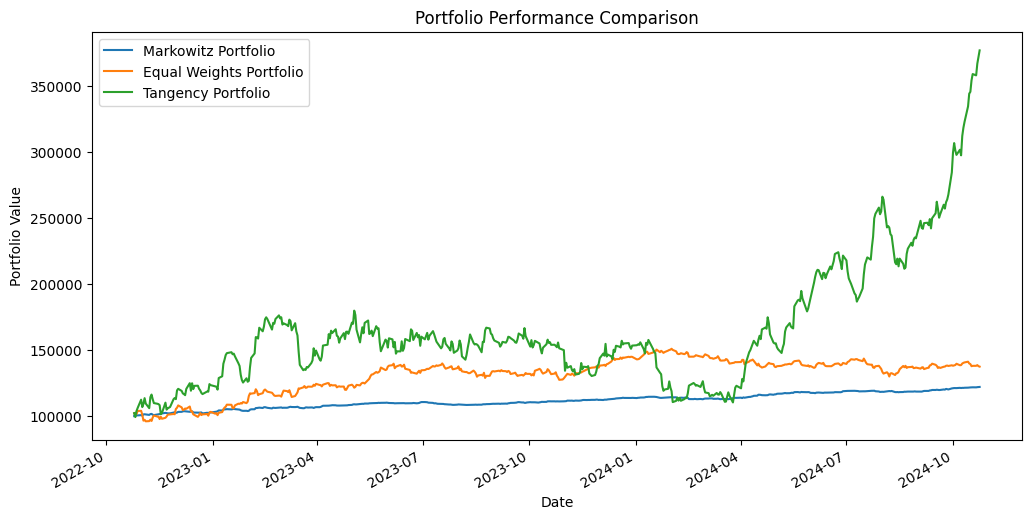

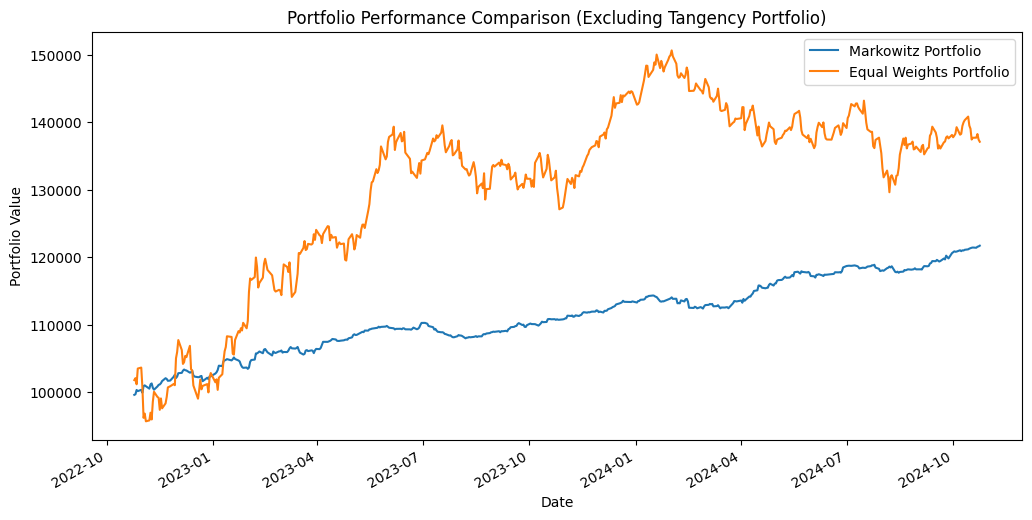

In [164]:
# Simulate the investment
simulation_results = simulate_investment(
    stock_returns=stock_returns,
    risk_free_rate=risk_free_rate,
    start_date='2022-10-25',
    end_date='2024-10-24',
    initial_capital=100000,
    min_return=0.13,
    calculate_minimum_risk_portfolio=calculate_minimum_risk_portfolio,
    return_variance_func=historical_mean_return_variance,
    tangency_weights=tangency_weights,
    tangency_weights_s=tangency_weights_s,
    short=True
)

simulation_results.plot(
    title="Portfolio Performance Comparison",
    ylabel="Portfolio Value",
    xlabel="Date",
    figsize=(12, 6)
);

simulation_results.drop(columns=['Tangency Portfolio']).plot(
    title="Portfolio Performance Comparison (Excluding Tangency Portfolio)",
    ylabel="Portfolio Value",
    xlabel="Date",
    figsize=(12, 6)
);

In [165]:
def calculate_portfolio_statistics(portfolio_values):
    """
    Calculate various statistics for a portfolio.
    
    Parameters:
        portfolio_values (pd.Series): Daily portfolio values.
        risk_free_rate (float): Daily risk-free rate (constant or time series).

    Returns:
        dict: Statistics including annualized return, volatility, and Sharpe ratio.
    """
    daily_returns = portfolio_values.pct_change().dropna()
    annualized_return = (portfolio_values.iloc[-1] / 100000) ** (252 / len(portfolio_values)) - 1
    annualized_volatility = daily_returns.std() * (252 ** 0.5)

    return {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility
    }

sp500_data['Close'] = pd.to_numeric(sp500_data['Close'], errors='coerce')
sp500_data['Open'] = pd.to_numeric(sp500_data['Open'], errors='coerce')
sp500_ret = np.log(sp500_data['Close'] / sp500_data['Open'])
sp500_return = np.round(sp500_ret.mean() * 252, 4)
sp500_return = sp500_return.item()
sp500_volatility = np.round(sp500_ret.std() * np.sqrt(252), 4)
sp500_volatility = sp500_volatility.item()

# Example usage for all portfolios
portfolio_stats = {}
for portfolio in simulation_results.columns:
    portfolio_stats[portfolio] = calculate_portfolio_statistics(simulation_results[portfolio])

# Display results
for portfolio, stats in portfolio_stats.items():
    print(f"{portfolio}:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.4f}")
print(f"S&P500:")
print(f"  Annualized Return: {sp500_return}")
print(f"  Annualized Volatility: {sp500_volatility}")

Markowitz Portfolio:
  Annualized Return: 0.1034
  Annualized Volatility: 0.0337
Equal Weights Portfolio:
  Annualized Return: 0.1714
  Annualized Volatility: 0.1583
Tangency Portfolio:
  Annualized Return: 0.9442
  Annualized Volatility: 0.4836
S&P500:
  Annualized Return: 0.1037
  Annualized Volatility: 0.1143


In [166]:
def calculate_worst_loss(portfolio_values):
    """
    Calculate the worst loss (maximum drawdown) for a portfolio.

    Parameters:
        portfolio_values (pd.Series): Portfolio values over time.

    Returns:
        float: Worst loss as the maximum drawdown.
    """
    # Calculate the running maximum value
    running_max = portfolio_values.cummax()
    
    # Calculate drawdown (difference between current value and running max)
    drawdown = (running_max - portfolio_values) / running_max
    
    # Find the maximum drawdown
    worst_loss = drawdown.max()
    trough_date = drawdown.idxmax().date()
    
    # Find the peak date (highest value before the trough)
    peak_date = portfolio_values[:trough_date].idxmax().date()
    
    return worst_loss, peak_date, trough_date


# Calculate worst loss for each portfolio
worst_losses = {}
for portfolio in simulation_results.columns:
    worst_losses[portfolio] = calculate_worst_loss(simulation_results[portfolio])

# Display results
print("Worst Loss (Maximum Drawdown) for Each Portfolio:")
for portfolio, (loss, peak_date, trough_date) in worst_losses.items():
    print(f"{portfolio}: {loss:.2%} (from {peak_date} to {trough_date})")

Worst Loss (Maximum Drawdown) for Each Portfolio:
Markowitz Portfolio: 2.08% (from 2023-07-03 to 2023-08-07)
Equal Weights Portfolio: 13.97% (from 2024-02-01 to 2024-08-07)
Tangency Portfolio: 38.77% (from 2023-05-03 to 2024-03-25)
